# Dunkin assessment

In [63]:
# some imports used throughout script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl

In [64]:
def encode_biscuit_type(dataframe, biscuits):
    """
    Add new column to dataframe, chaanging biscui names to integers. 

    Args:
        dataframe (df): dataframe containing 'biscuit' column
        biscuits (list): list of biscuit names in correct order
    """
    # check biscuit column exists
    # do a test?
    try:
        biscuit_column = dataframe['biscuit']
        for i, biscuit in enumerate(biscuits):
            biscuit_column = np.where([biscuit_column==biscuit], i, biscuit_column)[0]
            
        dataframe['encoded biscuit'] = biscuit_column
        
        print("added encoded biscuit column")
    except:
        raise ValueError("\"biscuit\" column does not exist in this dataframe.")

#### Big data collection

1. gamma: the tea surface tension, in N m−1
.
2. phi: the contact angle between the biscuit and the tea surface, in rad.
3. eta: the tea dynamic viscosity, in Pa s
4. L: the distance up the biscuit that the tea was visible, in m.
5. t: the time after initial dunking that the measurement was made, in s.
6. biscuit: the type of biscuit that was dunked, which is Rich Tea, Hobnob or Digestive.


In [65]:
# load in dunking-data, and show dataframe

big_data = pd.read_csv("dunking-data.csv")
print(f"shape: {big_data.shape}")
big_data.head()

shape: (3000, 6)


,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [66]:
# get names of all types of biscuits

biscuits = np.unique(big_data["biscuit"])
biscuits

array(['Digestive', 'Hobnob', 'Rich Tea'], dtype=object)

In [67]:
# encode names to integers

encode_biscuit_type(big_data, biscuits)
big_data.head()

added encoded biscuit column


,gamma,phi,eta,L,t,biscuit,encoded biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,0
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,0
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,0
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,1
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,1


# Classification of biscuit type 

In this section, a random forest classifier is trained and tested on the dunking-data.csv. It aims to be able to classify biscuit type from the provided data (phi,eta,L,t)



In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train, test = train_test_split(big_data, test_size=0.2)

scaler = StandardScaler()
scaled_training_features = scaler.fit_transform(train.drop(['biscuit', 'encoded biscuit'], axis=1))
scaled_test_features = scaler.fit_transform(test.drop(['biscuit', 'encoded biscuit'], axis=1))

In [69]:
# irrelevant?
train.head()

,gamma,phi,eta,L,t,biscuit,encoded biscuit
806,0.084730,1.445892,0.000985,0.009133,20.596109,Digestive,0
2552,0.071319,1.448089,0.000992,0.007092,19.680945,Hobnob,1
1110,0.065626,1.474339,0.000992,0.005111,28.839195,Rich Tea,2
2004,0.078618,1.368608,0.000997,0.007021,21.516621,Rich Tea,2
1616,0.073732,1.413341,0.000997,0.006730,24.821932,Rich Tea,2


In [70]:
training_results = np.array(train['encoded biscuit'].values, dtype=int)
training_results
# len(results.values)

array([0, 1, 2, ..., 1, 0, 2])

In [71]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=500, max_features=None)
RFC.fit(scaled_training_features, training_results)
predicted_test_vals= RFC.predict(scaled_test_features)
len(predicted_test_vals)

600

In [72]:
# from sklearn.svm import SVC

# SVC = SVC(verbose=1, C=1000, gamma=0.01)
# SVC.fit(scaled_training_features, training_results)
# predicted_test_vals= RFC.predict(scaled_test_features)
# len(predicted_test_vals)

In [73]:
# from sklearn.svm import SVC

# methods = {'SVM': SVC(random_state=42),
#             'Random Forest': RandomForestClassifier(random_state=42)}
# for k, v in methods.items():
#     print(k)
#     v.fit(scaled_training_features, training_results)
#     test[f'{k} Prediction'] = v.predict(scaled_test_features)

In [74]:
# encoding test values to ints

true_test_vals = np.array(test["encoded biscuit"].values, dtype=int)
len(true_test_vals)

600

In [75]:
# compare raw number of predicted biscuit types and true biscuit types

max_num_predictions = 0
for i, biscuit in enumerate(biscuits):
    num_true_test_vals = len(true_test_vals[true_test_vals == i])
    num_pred_test_vals = len(predicted_test_vals[predicted_test_vals == i])
    print( f"Number of true {biscuit} values: {num_true_test_vals}")
    print( f"Number of predicted {biscuit} values: {num_pred_test_vals}")
    
    max_num_predictions = max(max_num_predictions, num_pred_test_vals)

Number of true Digestive values: 199
Number of predicted Digestive values: 228
Number of true Hobnob values: 199
Number of predicted Hobnob values: 191
Number of true Rich Tea values: 202
Number of predicted Rich Tea values: 181


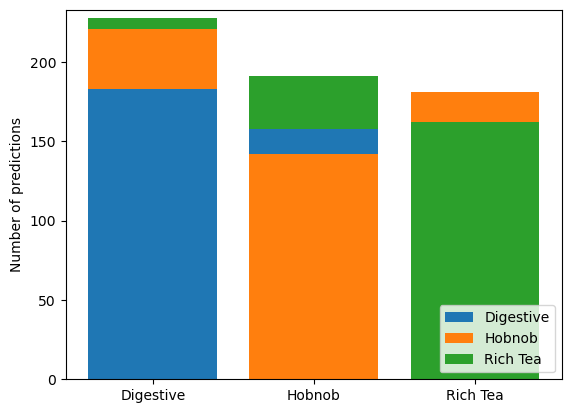

In [76]:
# plot bar chart

fig,ax = plt.subplots()

for i, biscuit in enumerate(biscuits):
    # Get values where this biscuit was predicted
    biscuit_prediction = np.where(predicted_test_vals==i, True, False)

    # Filter test values to just these biscuit predictions
    biscuit_test = true_test_vals[biscuit_prediction]
    
    # Number of correct predictions
    correct_predictions = len( biscuit_test[biscuit_test==i] )
    
    ax.bar(biscuit, correct_predictions, color=f"C{i}", label=biscuit)
    
    base = correct_predictions
    for j in range(len(biscuits)):
        if j != i:
            # NUmber of incorrect predictions, recording which biscuit was predicted instead
            incorrect_predictions = len( biscuit_test[biscuit_test==j] )
            ax.bar(biscuit, incorrect_predictions, bottom=base, color=f"C{j}")
            base += incorrect_predictions
            
ax.set_ylabel("Number of predictions")
ax.set_ylim(0, max_num_predictions+5)
ax.legend(loc="lower right");

In [77]:
# metrics

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'Precision: {precision:.3f}')

recall = recall_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'Recall: {recall:.3f}')

f1score = f1_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'F1-Score: {f1score:.3f}')

Precision: 0.814
Recall: 0.812
F1-Score: 0.811


In [78]:
importances = RFC.feature_importances_
feature_names = big_data.drop(['biscuit', 'encoded biscuit'],axis=1).columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
(feature_df)

,Feature,Gini Importance
3,L,0.337216
1,phi,0.295460
4,t,0.202415
0,gamma,0.110202
2,eta,0.054709


In [79]:
# use GridSearchCV
# param_grid = [
#   {'max_features': [ 0.25, 0.5, 0.75, 1.0, 'sqrt', 'log2', None]}
#  ]
# svc_param_grid = [
#   {'C': [1000],  
#   'gamma': [0.01], 
#   'kernel': ['linear', 'poly', 'rbf']} 
#  ]

In [80]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import f1_score, make_scorer

# # f1 = make_scorer(f1_score , average='weighted', pos_label=None)

# gscv = GridSearchCV(SVC, svc_param_grid)
# gscv.fit(scaled_training_features, training_results)
# gscv.best_estimator_

In [81]:
f1score = f1_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'F1-Score: {f1score:.3f}')

F1-Score: 0.811


#### comparison to true distribution

#### microscopy measurements

The final dataset was generated by taking a subset, one-sixth, of the dunking-data.csv samples and finding the pore radius by microscopy. This data file has similar information to the dunking-data.csv but without the biscuit type and with the pore radius. The columns, in order, are:

The final dataset is a subset of the training data.csv, where the biscuit type is no longer identified, but this has been replaced with the pore size as measured with microscopy. Therefore, this data also has six columns.

1. gamma: the tea surface tension, in N m−1
.
2. phi: the contact angle between the biscuit and the tea surface, in rad.
3. eta: the tea dynamic viscosity, in Pa s
4. L: the distance up the biscuit that the tea was visible, in m.
5. t: the time after initial dunking that the measurement was made, in s.
6. r: the radius of the pore, in m


In [82]:
microscopy_data = pd.read_csv("microscopy-data.csv")
microscopy_data.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


In [83]:
def washburn(gamma,r,t,phi,eta):
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    return L

In [84]:
# def predict_washburn_r(gamma,L,t,phi,eta):
#     numerator = (L**2)*2*eta
#     denominator = gamma*t*np.cos(phi)
    
#     r = numerator / denominator
    
#     return r

In [85]:
# irrelevant - adding L_wash and r_pred

# microscopy_data["L_wash"] = washburn(microscopy_data["gamma"], microscopy_data["r"], microscopy_data["t"], microscopy_data["phi"], microscopy_data["eta"])
# microscopy_data["r_pred"] = predict_washburn_r(microscopy_data["gamma"], microscopy_data["L"], microscopy_data["t"], microscopy_data["phi"], microscopy_data["eta"])
# # washburn(gamma,r,t,phi,eta)
# microscopy_data.head()

In [86]:
# irrelevant plot

# fig,ax=plt.subplots()

# ax.scatter(microscopy_data["L_wash"], microscopy_data["r_pred"], s=5)


In [87]:
test_micro = microscopy_data.drop(['r'], axis=1)
test_micro.head()

,gamma,phi,eta,L,t
0,0.084596,1.557367,0.000981,0.003221,24.231107
1,0.064291,1.538842,0.000998,0.002395,22.169765
2,0.086224,1.546138,0.001008,0.003036,23.257709
3,0.082859,1.566878,0.000997,0.001261,12.717432
4,0.090832,1.570229,0.001002,0.000576,15.189146


In [88]:
scaled_test_micro = scaler.fit_transform(test_micro)
scaled_test_micro

array([[ 1.14599561,  1.1356957 , -1.85755021, -0.89683791,  0.77167231],
       [-0.89539042,  0.94168794, -0.27453187, -1.15666199,  0.41612889],
       [ 1.30966628,  1.01809608,  0.72485416, -0.95478295,  0.6037792 ],
       ...,
       [ 0.09739798,  1.10899036, -0.32077567, -0.953279  , -0.30290994],
       [ 0.82621258, -0.09441766,  1.04595373,  0.95980465, -0.10701664],
       [ 1.37150823,  0.79061851,  0.6782453 , -0.96069037, -1.44258582]])

In [89]:
micro_predictions = RFC.predict(scaled_test_micro)
len(micro_predictions)


500

In [90]:
micro_predictions

array([0, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 2,
       0, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 0, 1, 1, 1, 2, 1,
       2, 1, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 1, 0, 2, 1, 2, 2, 0, 1, 2,
       0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2,
       1, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 0, 0, 0, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2, 0, 2, 1,
       0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 1, 1, 2,
       1, 0, 2, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 1, 2,
       1, 0, 2, 0, 0, 2, 2, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2, 2, 0, 2, 1, 1,
       0, 1, 0, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2,
       2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0,
       0, 1, 2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 1, 2,
       0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 2, 1, 1, 1,
       1, 0, 2, 0, 2, 2, 0, 1, 1, 2, 2, 1, 2, 0, 2,

In [91]:
# irrelevant plot

# fig,ax=plt.subplots()

# ax.scatter(microscopy_data["L_wash"], microscopy_data["r_pred"], s=5, c=micro_predictions)
# ax.set_xlabel("Predicted L")
# ax.set_ylabel("Predicted r")

In [92]:
training_merged = big_data.merge(microscopy_data, how='inner')
true_distributions = training_merged[['encoded biscuit', 'r']].copy()
true_distributions

,encoded biscuit,r
0,0,7.797961e-07
1,0,8.189772e-07
2,1,3.639434e-07
3,2,3.198697e-07
4,2,2.973448e-07
...,...,...
495,1,4.176549e-07
496,2,3.187500e-07
497,2,3.194081e-07
498,0,7.453712e-07


Text(0, 0.5, 'r')

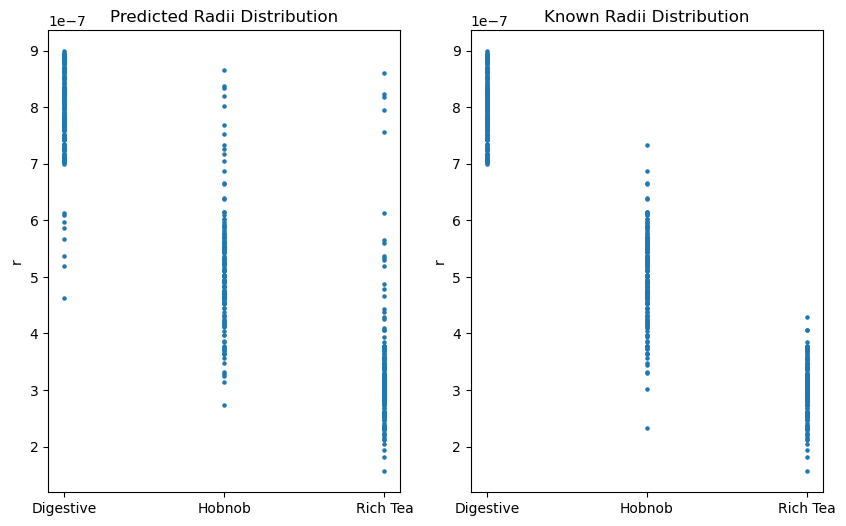

In [93]:
fig,ax=plt.subplots(1,2, figsize=(10,6))

ax[0].set_title("Predicted Radii Distribution")
ax[0].scatter(micro_predictions, microscopy_data["r"], s=5)
ax[0].set_xticks(np.arange(0, len(biscuits)))
ax[0].set_xticklabels(biscuits)
ax[0].set_ylabel("r")


ax[1].set_title("Known Radii Distribution")
ax[1].scatter(true_distributions['encoded biscuit'], true_distributions["r"], s=5)
ax[1].set_xticks(np.arange(0, len(biscuits)))
ax[1].set_xticklabels(biscuits)
ax[1].set_ylabel("r")

In [94]:
map0 = np.where(micro_predictions==0, True, False)
microscopy_data["r"][map0]

0      7.453712e-07
9      8.919035e-07
12     7.250476e-07
19     7.137298e-07
22     7.894797e-07
           ...     
491    6.095021e-07
492    8.991764e-07
496    8.798032e-07
497    8.652230e-07
498    8.128785e-07
Name: r, Length: 161, dtype: float64

In [95]:
from scipy.stats import norm

def get_norm_distribution(data):
    mean = np.mean(data)
    std = np.std(data)
    distribution = norm.rvs(mean, std)
    return distribution.pdf()

Digestive
predicted mean: 7.92e-07
true mean: 8.03e-07
predicted std: 7.85e-08
true std: 5.8e-08

Hobnob
predicted mean: 5.11e-07
true mean: 4.96e-07
predicted std: 1.08e-07
true std: 8e-08

Rich Tea
predicted mean: 3.32e-07
true mean: 3.04e-07
predicted std: 1.06e-07
true std: 4.7e-08



Text(0.5, 1.0, 'Known Radii Distributions')

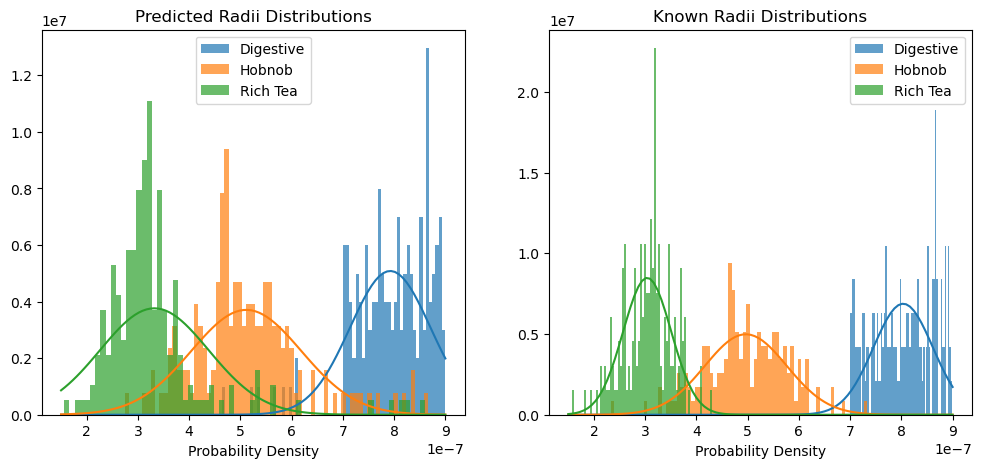

In [96]:
# plot as histogram

fig, ax = plt.subplots(1,2,figsize=(12,5))

pore_radii = []

for i, biscuit in enumerate(biscuits):
    print(f"{biscuit}")
    map = np.where(micro_predictions==i, True, False)
    biscuit_r_data = microscopy_data["r"][map]
    ax[0].hist(biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    
    true_biscuit_r_data = true_distributions["r"][true_distributions['encoded biscuit']==i]
    ax[1].hist(true_biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    
    mean, std = norm.fit(biscuit_r_data)
    # xmin, xmax = plt.xlim()
    x = np.linspace(1.5e-7, 9e-7, 100)
    p = (norm.pdf(x, mean, std))
    pore_radii.append(mean)
    ax[0].plot(x,p, color=f"C{i}")
    
    
    true_mean, true_std = norm.fit(true_biscuit_r_data)
    # xmin, xmax = plt.xlim()
    x = np.linspace(1.5e-7, 9e-7, 100)
    p = (norm.pdf(x, true_mean, true_std))
    ax[1].plot(x,p, color=f"C{i}")
    print(f"predicted mean: {mean:.3}")
    print(f"true mean: {true_mean:.3}")
    print(f"predicted std: {std:.3}")
    print(f"true std: {true_std:.3}\n")
    
ax[0].set_xlabel("Pore radius size / m")
ax[0].set_xlabel("Probability Density")
ax[0].legend()
ax[0].set_title("Predicted Radii Distributions")
ax[1].set_xlabel("Pore radius size / m")
ax[1].set_xlabel("Probability Density")
ax[1].legend()
ax[1].set_title("Known Radii Distributions")

#### Time-resolved measurements
Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension was measured at 6.78 × 10−2 N m−1.

• the contact angle was 1.45 rad.

• the tea dynamic viscosity was 9.93 × 10−4 Pa s.

The biscuit used for each measurement is unknown, and the data files are titled tr-1.csv, tr-2.csv, and tr-3.csv. Each data file contains the same information, three columns of experimental data:

1. t: the time elapsed in the measurement, in s, the dependent variable.
2. L: the length the tea has soaked up the biscuit, the independent variable, in m.
3. dL: an estimate of the uncertainty in length, also in m.

In [98]:
tr_1 = pd.read_csv("tr-1.csv")
tr_2 = pd.read_csv("tr-2.csv")
tr_3 = pd.read_csv("tr-3.csv")

tr_3.head()

,t,L,dL
0,30.000000,0.011187,0.000371
1,32.727273,0.011566,0.000609
2,35.454545,0.011942,0.000809
3,38.181818,0.012502,0.000614
4,40.909091,0.013343,0.000480


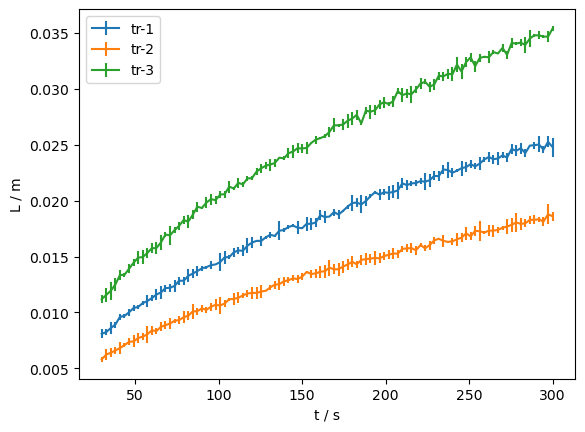

In [99]:
fig, ax = plt.subplots()

for i in range(1,4):
    data = pd.read_csv(f"tr-{i}.csv")
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    ax.errorbar(x,y,dy,label=f"tr-{i}")
    
ax.set_xlabel("t / s")
ax.set_ylabel("L / m")
ax.legend()

In [100]:
def washburn(gamma,r,t,phi,eta):
    """
    REDO
    A first order rate equation.
    
    :param gamma: The time to evaluate the rate equation at.
    :param r: The rate constant.
    :param t: The initial concentration of A.
    :param phi: The initial concentration of A.
    :param eta: The initial concentration of A.
    
    :return: The concentration of A at time t.
    """
    
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    return L

In [101]:
import pymc as pm
import arviz as az


def run_pymc(data):
    
    D = [norm(data['L'][i], data['dL'][i]) for i in range(len(data))]
    
    with pm.Model() as model:
        gamma = 6.78e-2
        r = pm.Uniform('r', 1.5e-7, 1.2e-6)
        phi = 1.45
        eta = 9.93e-4
        
        L = pm.Normal('t', 
                    mu=washburn(gamma,r,data["t"],phi,eta), 
                    sigma=data['dL'], 
                    observed=data['L'])
        
        trace = pm.sample(1000, tune=1000, chains=10, progressbar=True)
        

    az.plot_trace(trace, var_names=["r"])
    plt.tight_layout()
    plt.show()
    
    return float(trace.posterior["r"].mean()), float(trace.posterior["r"].mean())

In [102]:
# irrelevant - getting ideal r from washburn fits. 

# # fig, ax = plt.subplots()
# data_r_avs = []
# data_r_stds = []

# for i in range(1,4):
#     data = pd.read_csv(f"tr-{i}.csv")
#     x = data["t"]
#     y = data["L"]
#     dy = data["dL"]
    
#     data_r, data_std = run_pymc(data)
#     data_r_avs.append(data_r)
#     data_r_stds.append(data_std)


In [103]:
biscuits

array(['Digestive', 'Hobnob', 'Rich Tea'], dtype=object)

In [104]:
pore_radii

[7.924779536489041e-07, 5.114688121359469e-07, 3.32032406004953e-07]

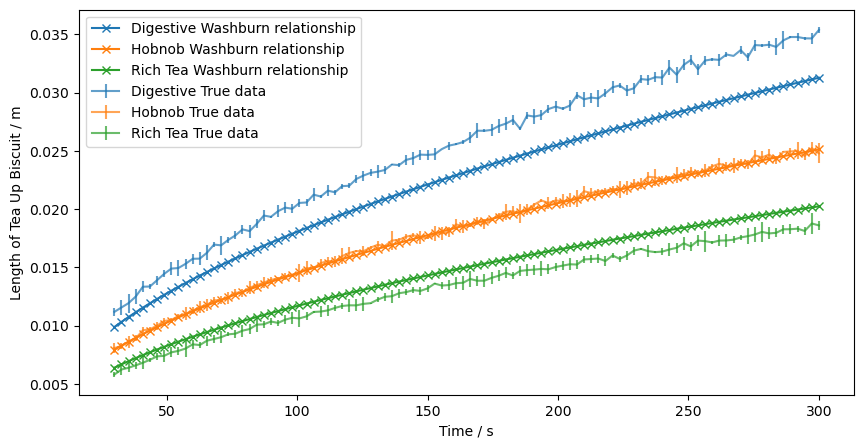

In [105]:
# washburn model fittings

fig, ax = plt.subplots(figsize=(10,5))

tr_list = [3,1,2]

for i, tr_val in enumerate(tr_list):
    data = pd.read_csv(f"tr-{tr_val}.csv")
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    washburn_data_rfc = washburn(6.78e-2, pore_radii[i], data["t"], 1.45, 9.93e-4 )
    ax.errorbar(x,y,dy,label=f"{biscuits[i]} True data", alpha=0.7, color=f"C{i}")
    
    ax.plot(data["t"], washburn_data_rfc, marker='x', color=f"C{i}", zorder=3, label=f'{biscuits[i]} Washburn relationship') 
    
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

#### regression

In [130]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


data = pd.read_csv(f"tr-3.csv")

poly = PolynomialFeatures(degree=2)
model = LinearRegression()

train, test = train_test_split(data, test_size=0.2, random_state=42)

X_ = poly.fit_transform(train["t"].values.reshape(-1,1))
y = train['L']

model.fit(X_, y)

reg_prediction = model.predict(X_)
####

X_test = test['t'].values.reshape(-1,1)
X_test_ = poly.fit_transform(X_test)

# true values
y_test = test['L'].values

mean_squared_error(y_test , model.predict(X_test_))

model.coef_

print("model:")
print(f"{model.coef_[0]:.4} t + {model.coef_[1]:.4} t**2 + {model.coef_[2]:.4} ")

model:
0.0 t + 0.0001327 t**2 + -1.467e-07 


In [107]:
def reg_model(r, t):
    return (1.54e+02*r + -1.8e+07*(r**2) + 2.16e-05)*t + (-0.254*r + 9.33e+04*(r**2) + -3.76e-09)*(t**2) + (3.96e+03*r + 3.74e+09*(r**2) + 0.00272)

In [134]:
gamma = 6.78e-2
phi = 1.45
eta = 9.93e-4

constant = np.sqrt(gamma*np.cos(phi)/2*eta)

In [135]:
def calc_constant(t):
    gamma = 6.78e-2
    phi = 1.45
    eta = 9.93e-4

    constant = np.sqrt(gamma*t*np.cos(phi)/2*eta)
    return constant

Digestive
[ 2.03044041e-03 -6.26007289e-08]
0.00203*t + -6.26e-08*(t**2) + 2.64e-05
RMSE for Washburn model: 0.0198
RMSE for Polynomial regression model: 0.000249


Hobnob
[ 1.51886381e-03 -2.56966516e-06]
0.00152*t + -2.57e-06*(t**2) + -0.0003
RMSE for Washburn model: 0.0137
RMSE for Polynomial regression model: 0.000194


Rich Tea
[1.05646313e-03 4.47610565e-07]
0.00106*t + 4.48e-07*(t**2) + 0.000112
RMSE for Washburn model: 0.00969
RMSE for Polynomial regression model: 0.00015




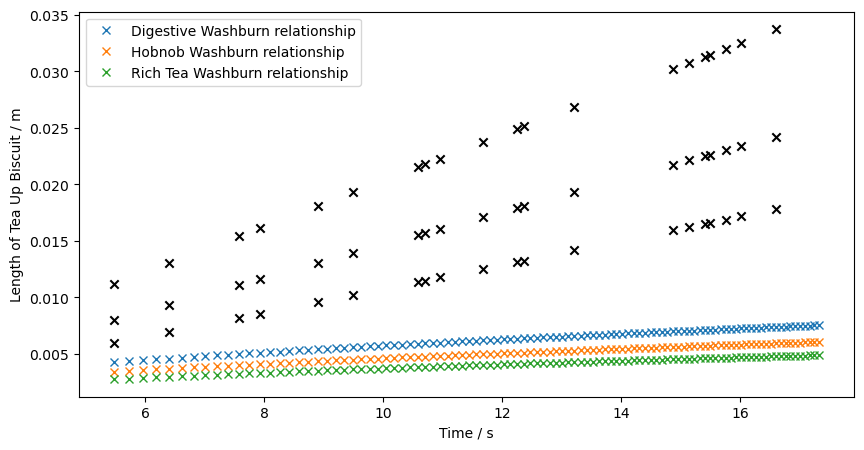

In [152]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


fig, ax = plt.subplots(figsize=(10,5))

tr_list = [3,1,2]
poly = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

coef0 = []
coef1 = []
intercepts = []

for i, tr_val in enumerate(tr_list):
    print(f"{biscuits[i]}")
    
    data = pd.read_csv(f"tr-{tr_val}.csv")
    data['t'] = np.sqrt(data['t'])
    x = data["t"].values.reshape(-1,1)
    y = data["L"]
    dy = data["dL"]
    data['L'] = data['L']
    # data['L'] = (constant*np.sqrt(pore_radii[i])) / data['L']
    
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    
    X_train = poly.fit_transform(train["t"].values.reshape(-1,1))
    y_train = train['L']
    
    model.fit(X_train, y_train)
    
    X_test = test['t'].values.reshape(-1,1)
    X_test_ = poly.fit_transform(X_test)
    
    y_test = test['L'].values
    
    def model_fit(t):
        print(model.coef_)
        model_fit = model.coef_[0]*t + model.coef_[1]*(t**2) + model.intercept_
        print(f"{model.coef_[0]:.3}*t + {model.coef_[1]:.3}*(t**2) + {model.intercept_:.3}")
        return model_fit
    
    coef0.append(model.coef_[0])
    coef1.append(model.coef_[1])
    intercepts.append(model.intercept_)
    
    washburn_data_rfc = washburn(6.78e-2, pore_radii[i], data["t"], 1.45, 9.93e-4 )
    # ax.errorbar(x,y,dy,label=f"{biscuits[i]} True data", alpha=0.4, color=f"C{i}")
    ax.scatter(test['t'], model_fit(test['t']), marker='x', c='black', zorder=4)
    # ax.plot(data['t'], reg_model(pore_radii[i], data['t']), label='reg model')
    
    ax.plot(data["t"], washburn_data_rfc, marker='x', linestyle="", color=f"C{i}", zorder=3, label=f'{biscuits[i]} Washburn relationship') 
    
    mse_wash = np.sqrt(mean_squared_error(y , washburn_data_rfc))
    mse_reg =  np.sqrt(mean_squared_error(y_test , model.predict(X_test_)))
    
    print(f"RMSE for Washburn model: {mse_wash:.3}")
    print(f"RMSE for Polynomial regression model: {mse_reg:.3}")
    # print(model.coef_)
    print(f"\n")
    
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

In [143]:
pore_radii

[7.924779536489041e-07, 5.114688121359469e-07, 3.32032406004953e-07]

In [ ]:
import jax as jnp

def f(x):
    """
    An example function for JAX. 
    :param x: input to the function.
    :return: output of the function.
    """
    return jnp.square(x) + jnp.log(x)

In [144]:
# determine relationship between pore size and polynomial coefficients


poly = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

relationships = [coef0, coef1, intercepts]
for relationship in relationships:
    X_ = poly.fit_transform(np.array(pore_radii).reshape(-1,1))
    y = relationship

    model.fit(X_, y)
       
    print(model.coef_)
    print(f"{model.intercept_:.3} + {model.coef_[0]:.3}*r + {model.coef_[1]:.3}*(r**2) ")

    # fit = model_fit(pore_radii)

# reg_prediction = model.predict(X_)
####




[1.08971059e+06 4.51014216e+11]
-0.134 + 1.09e+06*r + 4.51e+11*(r**2) 
[-1.45648285e+03  1.28944731e+09]
0.000354 + -1.46e+03*r + 1.29e+09*(r**2) 
[-2.75028739e+07  2.44467903e+13]
6.85 + -2.75e+07*r + 2.44e+13*(r**2) 


In [111]:
def reg_model(r, t):
    return (1.54e+02*r + -1.8e+07*(r**2) + 2.16e-05)*t + (-0.254*r + 9.33e+04*(r**2) + -3.76e-09)*(t**2) + (3.96e+03*r + 3.74e+09*(r**2) + 0.00272)

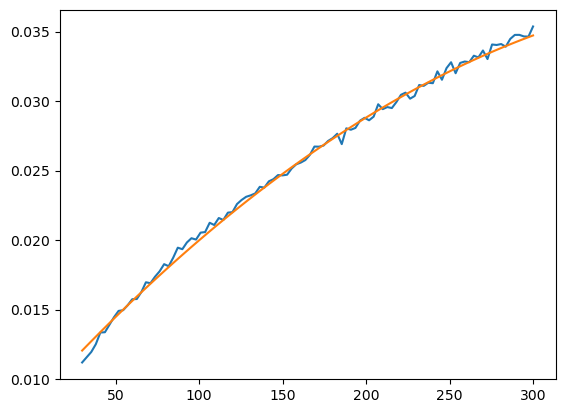

In [112]:
data = pd.read_csv("tr-3.csv")

fig,ax = plt.subplots()

ax.plot(data['t'], data['L'])
ax.plot(data['t'], reg_model(pore_radii[0], data['t']))

#### comparison of models

In [113]:
import numpy as np
from scipy.stats import norm

data = pd.read_csv("tr-3.csv")

data_distribution = [norm(loc=loc, scale=scale) for loc, scale in zip(data['L'], data['dL'])]

def likelihood(params, model):
    """
    A general likelihood function for a model with Gaussian errors.
    
    :param params: The parameters of the model.
    :param model: The model function.
    
    :return: The likelihood of the model given the data.
    """
    model_y = model(data['t'], params)
    return np.sum([d.logpdf(m) for d, m in zip(data_distribution, model_y)])

Digestive
predicted mean: 7.882179806307386e-07
true mean: 8.034291866766941e-07
predicted std: 8.18019913091328e-08
true std: 5.8005888939756295e-08

Hobnob
predicted mean: 5.165290698477061e-07
true mean: 4.96368880029679e-07
predicted std: 1.0527615756955756e-07
true std: 8.003103851757349e-08

Rich Tea
predicted mean: 3.297195784056182e-07
true mean: 3.038970573515411e-07
predicted std: 1.0690429827239919e-07
true std: 4.70262511627653e-08

In [114]:
from scipy.stats import uniform, norm

# priors about radius mean/ std
priors_one = [norm(220, 20)]   # 10 to 30

tr3_priors = [norm(7.9e-07, 8.2e-08)]  # distribution of radius


In [115]:
def prior_transform_one(u):
    """
    Transform the uniform random variables `u` to the model parameters.
    
    :param u: Uniform random variables
    
    :return: Model parameters
    """
    return [p.ppf(u_) for p, u_ in zip(tr3_priors, u)]

In [116]:
def washburn(gamma,r,t,phi,eta):
    """
    REDO
    A first order rate equation.
    
    :param gamma: The time to evaluate the rate equation at.
    :param r: The rate constant.
    :param t: The initial concentration of A.
    :param phi: The initial concentration of A.
    :param eta: The initial concentration of A.
    
    :return: The concentration of A at time t.
    """
    
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    # L at time t
    return L

In [117]:
def model_one(t, params):
    """
    A simpler single Gaussian model.
    
    :param t: The x values
    :param params: The model parameters
    
    :return: The y values
    """
    t=t.values.reshape(-1,1)
    r = params[0]
    # print(t)
    # print(params[0])
    gamma=6.78e-2
    phi=1.45
    eta=9.93e-4 
    
    L = washburn(gamma,r,t,phi,eta)
    
    # L at time t.
    return L

In [118]:
def likelihood_one(params):
    """
    The likelihood function for the simpler model.
    
    :param params: The model parameters
    
    :return: The likelihood
    """
    return likelihood(params, model_one)

In [119]:
import ultranest

sampler_one = ultranest.ReactiveNestedSampler(['r_dist'], likelihood_one, prior_transform_one)
sampler_one.run(show_status=False)
sampler_one.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=4e+02  
[ultranest] Likelihood function evaluations: 5325
[ultranest]   logZ = 411.3 +- 0.1195
[ultranest] Effective samples strategy satisfied (ESS = 1246.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.12 tail:0.03 total:0.12 required:<0.50
[ultranest] done iterating.

logZ = 411.318 +- 0.177
  single instance: logZ = 411.318 +- 0.141
  bootstrapped   : logZ = 411.286 +- 0.175
  tail           : logZ = +- 0.029
insert order U test : converged: True correlation: inf iterations

    r_dist              : 0.00000100284│ ▁  ▁▁▁▁▁▁▁▂▂▃▃▄▆▆▆▇▇▇▇▆▆▄▃▃▂▂▁▁▁▁▁ ▁▁ │0.00000100663    0.00000100482 +- 0.00000000045



In [120]:
# priors_two = tr3_priors

def prior_transform_two(u):
    """
    Transform the uniform random variables `u` to the model parameters for the more complex model.
    
    :param u: Uniform random variables
    
    :return: Model parameters
    """
    return [p.ppf(u_) for p, u_ in zip(tr3_priors, u)]

In [121]:
# poly = PolynomialFeatures(degree=2)
# X_ = poly.fit_transform(data['t'].values.reshape(-1,1))
# model = LinearRegression()
# model.fit(X_, y)

In [122]:
def model_two(t, params):
    """
    A more complex double Gaussian model.
    
    :param t: The time values
    :param params: The model parameters
    
    :return: The y values
    """
    t = t.values.reshape(-1,1)
    
    # print(X_.shape)
    r = params[0]
    # y = np.full((t.shape[0], 1), params[0])
    # print(y)
    # print(y.ravel())
    # print(y.shape)
    
    L_prediction = (1.54e+02*r + -1.8e+07*(r**2) + 2.16e-05)*t + (-0.254*r + 9.33e+04*(r**2) + -3.76e-09)*(t**2) + (3.96e+03*r + 3.74e+09*(r**2) + 0.00272)
    
    # reg_prediction = model.predict(t)
    
    return L_prediction

def likelihood_two(params):
    """
    The likelihood function for the more complex model.
    
    :param params: The model parameters
    
    :return: The likelihood
    """
    return likelihood(params, model_two)



In [123]:
sampler_two = ultranest.ReactiveNestedSampler(['r_dist'], likelihood_two, prior_transform_two)
sampler_two.run(show_status=False)
sampler_two.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=1e+02  
[ultranest] Likelihood function evaluations: 4181
[ultranest]   logZ = 118.1 +- 0.08083
[ultranest] Effective samples strategy satisfied (ESS = 1228.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.08 tail:0.04 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = 118.114 +- 0.165
  single instance: logZ = 118.114 +- 0.116
  bootstrapped   : logZ = 118.099 +- 0.161
  tail           : logZ = +- 0.035
insert order U test : converged: True correlation: inf iterations

    r_dist              : 0.00000079844│ ▁▁▁▁▁▁▁▁▂▂▃▄▄▅▇▇▇▇▇▇▆▇▅▃▃▃▂▁▁▁▁▁▁▁▁ ▁ │0.00000080011    0.00000079924 +- 0.00000000021



In [124]:
sampler_two.results['logz'], sampler_two.results['logzerr']

(118.11370591977399, 0.16461204304416047)

In [125]:
log_B = sampler_two.results['logz'] - sampler_one.results['logz']
log_B

-293.204602694707

Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension was measured at 6.78 × 10−2 N m−1.

• the contact angle was 1.45 rad.

• the tea dynamic viscosity was 9.93 × 10−4 Pa s.

Assessment: You have been tasked with investigating the available data and outlining
the analysis that you have performed in a written report. The aim is not to do the
most analysis possible but to find a coherent story in the analysis and present
this. Some examples of questions that the team are interested in include:

• Can a machine learning algorithm be used to identify the different types of biscuits? YES, USING RFC

• How is the pore radius different between the three types of biscuits? HISTOGRAM DONE

• How accurate is the Washburn equation for biscuits, and can a machine learning
regressor perform better? GOOD FOR HOBNOBS, BAD FOR OTHERS

You have been asked to write a report on the available data, perform an analysis, and
outline the data results. Furthermore, highlight and describe how the team might use
these data in future data-driven investigations.